# Nonlinear bias using generalized tracers and power spectra
This example showcases how to do nonlinear biasing with the generalized tracers and 2D power spectra implemented in CCL.

For more on generalized tracers and power spectra, see GeneralizedTracers.ipynb

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
import pyccl.nl_pt as pt
import pyccl.ccllib as lib
%matplotlib inline
print(ccl.__version__)

3.0.0


Note that the perturbation theory functionality lives within `pyccl.nl_pt`.

## Preliminaries
Let's just begin by setting up a cosmology and some biases

In [2]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# Biases for number counts 
b_1 = 2.0 # constant values for now
b_2 = 1.0
b_s = 1.0

# Biases for IAs. Will be converted to the input c_IA values below.
a_1 = 1.
a_2 = 0.5
a_d = 0.5

## PT tracers
Power spectra are Fourier-space correlations between two quantities. In CCL the quantities you want to correlate are defined in terms of so-called `PTTracers`.

### IA normalization
But before that, a few notes about the normalization of the IA biases

In [3]:
# Define a redshift range and associated growth factor:
z = np.linspace(0,1,128)
gz = ccl.growth_factor(cosmo, 1./(1+z))

# Let's convert the a_IA values into the correctly normalized c_IA values:
Om_m = cosmo['Omega_m']
rho_crit = lib.cvar.constants.RHO_CRITICAL
rho_m = lib.cvar.constants.RHO_CRITICAL * cosmo['Omega_m']
Om_m_fid = 0.3  # or could use DES convention and just remove Om_m/Om_m_fid

c_1_t = -1*a_1*5e-14*rho_crit*cosmo['Omega_m']/gz
c_d_t = -1*a_d*5e-14*rho_crit*cosmo['Omega_m']/gz
c_2_t = a_2*5*5e-14*rho_crit*cosmo['Omega_m']**2/(Om_m_fid*gz**2)  # Blazek2019 convention
c_2_t = a_2*5*5e-14*rho_crit*cosmo['Omega_m']/(gz**2)  # DES convention

# Or we just use the built-in function for IA normalization
c_1,c_d,c_2 = pt.translate_IA_norm(cosmo, z=z, a1=a_1, a1delta=a_d, a2=a_2,
                                   Om_m2_for_c2 = False)

### Tracers
OK, now that we have the biases, let's create three `PTTracer`s. One for number counts (galaxy clustering), one for intrinsic alignments and one for matter.

In [4]:
# Number counts
ptt_g = pt.PTNumberCountsTracer(b1=b_1, b2=b_2, bs=b_s)

# Intrinsic alignments
ptt_i = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1), c2=(z,c_2), cdelta=(z,c_d))
ptt_i_nla = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1)) # to compare using the standard WLTracer

# Matter
ptt_m = pt.PTMatterTracer()

# Note that we've assumed constant biases for simplicity, but you can also make them z-dependent:
bz = b_1 / gz
ptt_g_b = pt.PTNumberCountsTracer(b1=(z, bz))

## Eulerian PT calculator
Another object, `EulerianPTCalculator` takes care of initializing FastPT. You'll need one of these before you can compute P(k)s.

In [5]:
# The `with_NC` and `with_IA` flags will tell FastPT to initialize the right things.
# `log10k_min/max and nk_per_decade will define the sampling in k you should use.
ptc_euler = pt.EulerianPTCalculator(with_NC=True, with_IA=True,
                      log10k_min=-4, log10k_max=2, nk_per_decade=20)

Now we need to initialize the `ptc` object, i.e. essentially precomputing some of the stuff it needs to get you PT power spectra.

In [6]:
ptc_euler.update_ingredients(cosmo)

## PT power spectra
Let's compute some power spectra! We do so by calling `get_biased_pk2d` with whatever tracers you want to cross-correlate. This will return a `Pk2D` object that you can then evaluate at whatever scale and redshift you want.

In [7]:
# Galaxies x galaxies.
# If `tracer2` is missing, an auto-correlation for the first tracer is assumed.
pk_gg = ptc_euler.get_biased_pk2d(ptt_g)

# Galaxies x matter
pk_gm = ptc_euler.get_biased_pk2d(ptt_g, tracer2=ptt_m)

# Galaxies x IAs
pk_gi = ptc_euler.get_biased_pk2d(ptt_g, tracer2=ptt_i)

# IAs x IAs
pk_ii = ptc_euler.get_biased_pk2d(ptt_i, tracer2=ptt_i) 
pk_ii_bb = ptc_euler.get_biased_pk2d(ptt_i, tracer2=ptt_i, return_ia_bb=True)
pk_ii_nla = ptc_euler.get_biased_pk2d(ptt_i_nla, tracer2=ptt_i_nla)

# IAs x matter
pk_im = ptc_euler.get_biased_pk2d(ptt_i, tracer2=ptt_m)

# Matter x matter
pk_mm = ptc_euler.get_biased_pk2d(ptt_m, tracer2=ptt_m)


/Users/niko/anaconda3/envs/FISK_LSST/lib/python3.11/site-packages/pyccl/nl_pt/ept.py:375: CCLWarning: EulerianPTCalculators assume linear galaxy bias when computing galaxy-IA cross-correlations.
  warnings.warn(


**Note:** FastPT is not yet able to compute IAs x galaxies in a consistent way. What CCL does is to use the full non-linear model for IAs, but use a linear bias for galaxies.

OK, let's now plot a few of these!

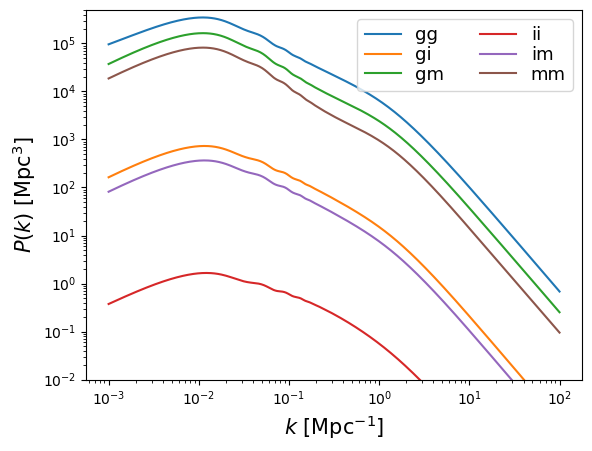

In [8]:
# Let's plot everything at z=0

ks = np.logspace(-3,2,512)
ps_euler = {}
ps_euler['gg'] = pk_gg(ks, 1., cosmo)
ps_euler['gi'] = pk_gi(ks, 1., cosmo)
ps_euler['gm'] = pk_gm(ks, 1., cosmo)
ps_euler['ii'] = pk_ii(ks, 1., cosmo)
ps_euler['im'] = pk_im(ks, 1., cosmo)
ps_euler['mm'] = pk_mm(ks, 1., cosmo)

euler_data = {
    "k": ks,
    "gg": ps_euler["gg"],
    "gi": -ps_euler["gi"],
    "gm": ps_euler["gm"],
    "ii": ps_euler["ii"],
    "im": -ps_euler["im"],
    "mm": ps_euler["mm"],
}

np.save("data/euler_data.npy", euler_data)

plt.figure()
for pn, p in ps_euler.items():
    plt.plot(ks, abs(p), label=pn)
plt.loglog()
plt.legend(loc='upper right', ncol=2,
           fontsize=13, labelspacing=0.1)
plt.ylim([1E-2, 5E5])
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^{3}]$', fontsize=15)
plt.show()

We can also compute the B-mode power spectrum for intrinsic alignments:

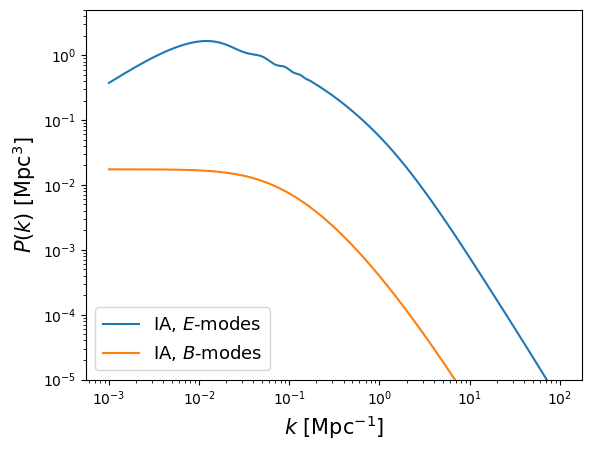

In [9]:
plt.figure()
plt.plot(ks, pk_ii(ks, 1., cosmo), label='IA, $E$-modes')
plt.plot(ks, pk_ii_bb(ks, 1., cosmo), label='IA, $B$-modes')
plt.loglog()
plt.legend(loc='lower left', fontsize=13)
plt.ylim([1E-5, 5E0])
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^{3}]$', fontsize=15)
plt.show()

## Angular power spectra
We can now use these P(k)s to compute angular power spectra, passing them to `ccl.angular_cl`.
Let's illustrate this specifically for the usual 3x2pt. We will define three standard tracers (not `PTTracer`s, but the ones used to compute angular power spectra), one for number counts, one for weak lensing shear, and one for intrinsic alignments, which is also a WeakLensingTracer. The first one will be associated with `PTNumberCountsTracer`, the second with `PTMatterTracer`, and the third with `PTIntrinsicAlignmentTracer`.

In [10]:
z = np.linspace(0, 1.5, 1024)
nz = np.exp(-((z-0.7)/0.1)**2)

# Number counts
# We give this one a bias of 1, since we've taken care of galaxy bias at the P(k) level.
t_g = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz), bias=(z, np.ones_like(z)), mag_bias=None)

# Lensing
t_l = ccl.WeakLensingTracer(cosmo, dndz=(z, nz))

# Intrinsic alignments
# Note the required settings to isolate the IA term and set the IA bias to 1,
# since we have added the IA bias terms at the P(k) level.
t_i = ccl.WeakLensingTracer(cosmo, dndz=(z, nz), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=False)
t_i_nla = ccl.WeakLensingTracer(cosmo, dndz=(z, nz), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=True)


Now compute power spectra. Note how we pass the P(k)s we just calculated as `p_of_k_a`.

In [11]:
ell = np.unique(np.geomspace(2,1000,100).astype(int)).astype(float)
cls={}
cls['gg'] = ccl.angular_cl(cosmo, t_g, t_g, ell, p_of_k_a=pk_gg)
cls['gG'] = ccl.angular_cl(cosmo, t_g, t_l, ell, p_of_k_a=pk_gm)
cls['GG'] = ccl.angular_cl(cosmo, t_l, t_l, ell, p_of_k_a=pk_mm)
cls['GI'] = ccl.angular_cl(cosmo, t_l, t_i, ell, p_of_k_a=pk_im)
cls['GI,NLA'] = ccl.angular_cl(cosmo, t_l, t_i_nla, ell)
cls['II'] = ccl.angular_cl(cosmo, t_i, t_i, ell, p_of_k_a=pk_ii)
cls['II,NLA'] = ccl.angular_cl(cosmo, t_i_nla, t_i_nla, ell)

Plot away!

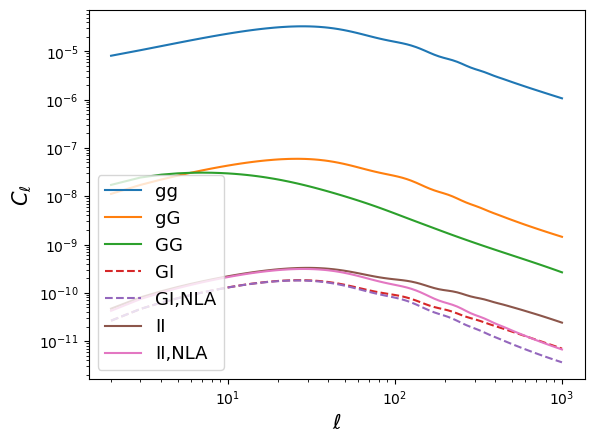

In [12]:
plt.figure()
for cn, c in cls.items():
    if c[0]>0:
        plt.plot(ell, c, label=cn)
    else:
        plt.plot(ell, abs(c), '--', label=cn)
plt.loglog()
plt.legend(loc='lower left', ncol=1, fontsize=13)
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.show()


## Lagrangian PT calculator
Another object, `LagrangianPTCalculator` takes care of initializing velocileptors. You'll need one of these before you can compute P(k)s.

In [13]:
# `log10k_min/max and nk_per_decade will define the sampling in k you should use.
ptc_lagrange = pt.LagrangianPTCalculator(log10k_min=-4, log10k_max=2, nk_per_decade=20)

Now we need to initialize the `ptc` object, i.e. essentially precomputing some of the stuff it needs to get you PT power spectra.

In [14]:
ptc_lagrange.update_ingredients(cosmo)

## PT power spectra
Let's compute some power spectra! We do so by calling `get_pt_pk2d` with whatever tracers you want to cross-correlate. This will return a `Pk2D` object that you can then evaluate at whatever scale and redshift you want.

In [15]:
# Galaxies x galaxies.
# If `tracer2` is missing, an auto-correlation for the first tracer is assumed.
pk_gg = ptc_lagrange.get_biased_pk2d(ptt_g)

# Galaxies x matter
pk_gm = ptc_lagrange.get_biased_pk2d(ptt_g, tracer2=ptt_m)

# Matter x matter
pk_mm = ptc_lagrange.get_biased_pk2d(ptt_m, tracer2=ptt_m)


**Note:** `LagrangianPTCalculator` does not calculate IA power spectra.

OK, let's now plot a few of these!

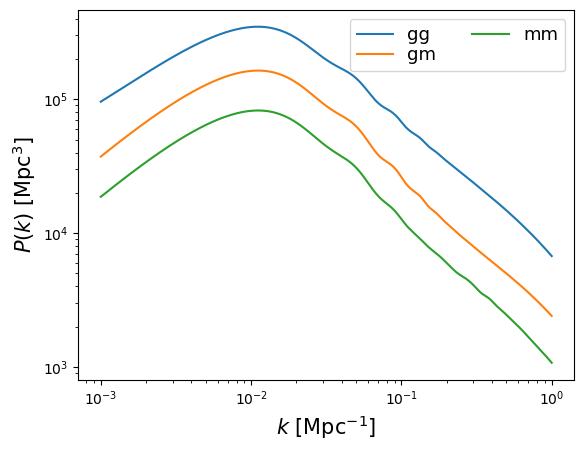

In [16]:
# Let's plot everything at z=0

ks_l = np.logspace(-3,0,512)
ps_lagrange = {}
ps_lagrange['gg'] = pk_gg(ks_l, 1., cosmo)
ps_lagrange['gm'] = pk_gm(ks_l, 1., cosmo)
ps_lagrange['mm'] = pk_mm(ks_l, 1., cosmo)

lagrange_data = {
    "k": ks_l,
    "gg": ps_lagrange["gg"],
    "gm": ps_lagrange["gm"],
    "mm": ps_lagrange["mm"],
}

pert_pk_data = {
    "euler": euler_data,
    "lagrange": lagrange_data,
}

np.save("data/pert_pk_data.npy", pert_pk_data)

plt.figure()
for pn, p in ps_lagrange.items():
    plt.plot(ks_l, abs(p), label=pn)
plt.loglog()
plt.legend(loc='upper right', ncol=2,
           fontsize=13, labelspacing=0.1)
# plt.ylim([1E-2, 5E5])
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^{3}]$', fontsize=15)
plt.show()

## Angular power spectra
We can now use these P(k)s to compute angular power spectra, passing them to `ccl.angular_cl`.
Let's illustrate this specifically for the usual 3x2pt. We will define two standard tracers (not `PTTracer`s, but the ones used to compute angular power spectra), one for number counts, one for weak lensing shear. The first one will be associated with `PTNumberCountsTracer`, the second with `PTMatterTracer`.

In [ ]:
z = np.linspace(0, 1.5, 1024)
nz = np.exp(-((z-0.7)/0.1)**2)

# Number counts
# We give this one a bias of 1, since we've taken care of galaxy bias at the P(k) level.
t_g = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz), bias=(z, np.ones_like(z)), mag_bias=None)

# Lensing
t_l = ccl.WeakLensingTracer(cosmo, dndz=(z, nz))

Now compute power spectra. Note how we pass the P(k)s we just calculated as `p_of_k_a`.

In [ ]:
ell = np.unique(np.geomspace(2,1000,100).astype(int)).astype(float)
cls={}
cls['gg'] = ccl.angular_cl(cosmo, t_g, t_g, ell, p_of_k_a=pk_gg)
cls['gG'] = ccl.angular_cl(cosmo, t_g, t_l, ell, p_of_k_a=pk_gm)

Plot away!

In [ ]:
plt.figure()
for cn, c in cls.items():
    if c[0]>0:
        plt.plot(ell, c, label=cn)
    else:
        plt.plot(ell, abs(c), '--', label=cn)
plt.loglog()
plt.legend(loc='lower left', ncol=1, fontsize=13)
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.show()
